<a href="https://colab.research.google.com/github/sfekih/2020/blob/master/projet_final_iapr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PROJECT_PATH = os.path.join('drive', 'My Drive', 'Colab Notebooks', 'iapr', 'train_games')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir(PROJECT_PATH)
!pwd

/content/drive/My Drive/Colab Notebooks/iapr/train_games


In [4]:
ls

game1/  game2/  game3/  game4/  game5/  game6/  game7/


In [5]:
#cd ..

In [6]:
import pandas as pd
import numpy as np

from PIL import Image
from scipy.spatial import distance_matrix


In [7]:
import os

In [9]:
def separate_columns(row, game_nb) :
  row['P1_suit'] = row.P1[1]
  row['P1_digit'] = row.P1[0]
  row['P2_suit'] = row.P2[1]
  row['P2_digit'] = row.P2[0]
  row['P3_suit'] = row.P3[1]
  row['P3_digit'] = row.P3[0]
  row['P4_digit'] = row.P4[1]
  row['P4_suit'] = row.P4[0]
  row['game_nb'] = game_nb
  return row

In [10]:
import cv2
import matplotlib.pyplot as plt


In [11]:
#read as BGR


In [12]:
def get_green_contours (img) :
  ## convert to hsv
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  ## mask of green (36,25,25) ~ (86, 255,255)
  # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
  mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

  ## slice the green
  imask = mask>0
  green = np.zeros_like(img, np.uint8)
  green[imask] = 255
  greyscale = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)
  return greyscale


In [85]:
def find_suits (contours_card) :
  centers = np.zeros((len(contours_card), 2))
  for i in range (0, len(contours_card)):
    M = cv2.moments(contours_card[i])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centers[i, 0] = cX
    centers[i, 1] = cY

  distances = distance_matrix(centers, centers)
  (suit1, val), suit2 = max(map(lambda x: (max(enumerate(x[1]), key= lambda x: x[1]), x[0]),
                                enumerate(distances)),
                              key=lambda x: x[0][1])

  return suit1, suit2

def get_contours_one_card (img, ordered_contours_cards, num_player):
  cimg_copy = np.zeros((img.shape[0], img.shape[1]))

  one_card = cv2.drawContours(cimg_copy.copy(), ordered_contours_cards.copy(), num_player, color=255, thickness=-1)

  mask_cards_only = one_card < 1
  img_cards_only = img.copy()
  img_cards_only[mask_cards_only, : ] = 0

  greyscale_one_card = cv2.cvtColor(img_cards_only.copy(), cv2.COLOR_BGR2GRAY)

  _,img_cards_only_copy = cv2.threshold(greyscale_one_card.copy(),180,255,cv2.THRESH_BINARY)

  img_cards_only_copy = np.rot90(img_cards_only_copy, k=num_player)

  contours_card, _ = cv2.findContours(img_cards_only_copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


  contours_card = [contour_ for contour_ in contours_card if cv2.contourArea(contour_)>500]
  contours_card = sorted(contours_card, key=lambda x: cv2.contourArea(x))[::-1][1:]

  return contours_card


def get_needed_contours (contours_card, used_for:str, suit1, suit2):

  if used_for=='digits':
    final_contours = [contours_card[i] for i in range (0, len(contours_card)) if (i!=suit1 and i!=suit2)]
  elif used_for=='suits':
    final_contours = [contours_card[j] for j in range (0, len(contours_card)) if (j==suit1 or j==suit2)]
  else :
    raise NameError ("parameter used_for should be 'digits' or 'suits'")

  
  min_x = np.min(final_contours[0][:,0,0])
  min_y = np.min(final_contours[0][:,0,1])

  for i in range (len(final_contours)) :
    final_contours[i][:,0,0] = final_contours[i][:,0,0] - min_x + 1
    final_contours[i][:,0,1] = final_contours[i][:,0,1] - min_y + 1
  if used_for=='digits':
    img_cards_only_copy = np.zeros((350, 350))
  else :
    img_cards_only_copy = np.zeros((150, 150))

  drawn_contour = cv2.drawContours(img_cards_only_copy, final_contours, -1, color=255, thickness=-1)
  return drawn_contour

In [108]:
digits = []
suits = []

In [117]:
games_paths = sorted(['game'+str(i) for i in range (1, 8)])
rounds_paths = sorted([str(i)+'.jpg' for i in range (1, 14)])
total_results = pd.DataFrame()

for game_nb in range (0, len(games_paths)) :
  
  results_path = games_paths[game_nb] + '/' + 'game'+str(game_nb + 1)+'.csv'



  data_game_1 = pd.read_csv(results_path)
  data_game_preprocessed = data_game_1.apply(lambda x: separate_columns(x, game_nb+1), axis=1)\
                                      .drop(columns={'P1', 'P2', 'P3', 'P4'})\
                                      .rename(columns={'Unnamed: 0':'round_nb'})

  total_results = total_results.append(data_game_preprocessed)

  for round_nb in range (len(rounds_paths)) :
    round = rounds_paths[round_nb]
    image_path = games_paths[game_nb] + '/' + round
    img = cv2.imread(image_path)

    try :
      
      green_contours = get_green_contours(img)
      kernel = np.ones((5,5),np.uint8)
      dilation = cv2.dilate(green_contours,kernel,iterations = 2)
      hull = []

      contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      for i in range(len(contours)):
          hull.append(cv2.convexHull(contours[i], False))
      cntsSorted = sorted(hull, key=lambda x: cv2.arcLength(x, True))[::-1][:5]


      cimg = np.zeros_like(green_contours)
      cimg_copy = cimg
      centers = np.zeros((5, 2))
      for i in range (5):    
        M = cv2.moments(cntsSorted[i])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers[i, 0] = cX
        centers[i, 1] = cY

      centers_cards = centers[:-1,:]
      center_badge = centers[-1,:]
      player1 = np.argmax(centers_cards[:,1])
      player3 = np.argmin(centers_cards[:,1])
      player2 = np.argmin(centers_cards[:,0])
      player4 = np.argmax(centers_cards[:,0])
      players_args = [player1, player2, player3, player4]
      centers_ordered = np.array([centers_cards[i,:] for i in players_args])
      ordered_contours_cards = [cntsSorted[i] for i in players_args]

      cards_only = cv2.drawContours(cimg.copy(), ordered_contours_cards.copy(), -1, color=255, thickness=-1)
      cards_and_badge = cv2.drawContours(cimg.copy(), ordered_contours_cards.copy(), -1, color=255, thickness=-1)
      cimg_2 = cv2.drawContours(cimg.copy(), cntsSorted, -1, color=255, thickness=-1)

      centers_distances = np.array([np.linalg.norm(centers_ordered[i, :]-center_badge) for i in range (4)])
      badge_idx = np.argmin(centers_distances)


      for iter in range (0, 4) :
        
        contours_card = get_contours_one_card (img, ordered_contours_cards, iter)

        suit1, suit2 = find_suits (contours_card)
        digits.append(get_needed_contours (contours_card, 'digits', suit1, suit2))
        suits.append(get_needed_contours (contours_card, 'suits', suit1, suit2))
    except Exception:
      print(image_path)

game1/13.jpg
game1/4.jpg
game1/5.jpg
game1/7.jpg
game3/1.jpg
game3/11.jpg
game3/12.jpg
game3/13.jpg
game3/3.jpg
game3/6.jpg
game3/8.jpg
game4/1.jpg
game4/11.jpg
game4/13.jpg
game4/5.jpg
game4/8.jpg
game4/9.jpg
game5/10.jpg
game5/2.jpg
game5/6.jpg
game5/8.jpg
game6/11.jpg
game6/4.jpg
game6/6.jpg
game7/1.jpg
game7/10.jpg
game7/11.jpg
game7/12.jpg
game7/13.jpg
game7/2.jpg
game7/3.jpg
game7/4.jpg
game7/5.jpg
game7/6.jpg
game7/7.jpg
game7/8.jpg
game7/9.jpg


In [ ]:
assert(1==2)

In [98]:
def get_contours_one_card (img, ordered_contours_cards, num_player):
  cimg_copy = np.zeros((img.shape[0], img.shape[1]))

  one_card = cv2.drawContours(cimg_copy.copy(), ordered_contours_cards.copy(), num_player, color=255, thickness=-1)
  mask_cards_only = one_card < 1
  img_cards_only = img.copy()
  img_cards_only[mask_cards_only, : ] = 0

  greyscale_one_card = cv2.cvtColor(img_cards_only.copy(), cv2.COLOR_BGR2GRAY)

  _,img_cards_only_copy = cv2.threshold(greyscale_one_card.copy(),180,255,cv2.THRESH_BINARY)

  img_cards_only_copy = np.rot90(img_cards_only_copy, k=num_player)

  contours_card, _ = cv2.findContours(img_cards_only_copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


  contours_card = [contour_ for contour_ in contours_card if cv2.contourArea(contour_)>500]
  contours_card = sorted(contours_card, key=lambda x: cv2.contourArea(x))[::-1][1:]

  return contours_card

[[2928. 2120.]
 [1810.  767.]
 [ 547. 2259.]
 [1727. 3309.]
 [ 900. 3711.]]
3 2 1
3 1 0
5 4 2
3 2 1


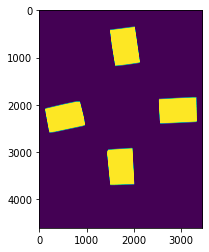

In [112]:
img = cv2.imread('game1/10.jpg')
green_contours = get_green_contours(img)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(green_contours,kernel,iterations = 2)
hull = []

contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    hull.append(cv2.convexHull(contours[i], False))
cntsSorted = sorted(hull, key=lambda x: cv2.arcLength(x, True))[::-1][:5]


cimg = np.zeros_like(green_contours)
cimg_copy = cimg
centers = np.zeros((5, 2))
for i in range (5):    
  M = cv2.moments(cntsSorted[i])
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  centers[i, 0] = cX
  centers[i, 1] = cY

print(centers)
centers_cards = centers[:-1,:]
center_badge = centers[-1,:]
player1 = np.argmax(centers_cards[:,1])
player3 = np.argmin(centers_cards[:,1])
player2 = np.argmin(centers_cards[:,0])
player4 = np.argmax(centers_cards[:,0])
players_args = [player1, player2, player3, player4]
centers_ordered = np.array([centers_cards[i,:] for i in players_args])
ordered_contours_cards = [cntsSorted[i] for i in players_args]

cards_only = cv2.drawContours(cimg.copy(), ordered_contours_cards.copy(), -1, color=255, thickness=-1)
cards_and_badge = cv2.drawContours(cimg.copy(), ordered_contours_cards.copy(), -1, color=255, thickness=-1)
cimg_2 = cv2.drawContours(cimg.copy(), cntsSorted, -1, color=255, thickness=-1)

centers_distances = np.array([np.linalg.norm(centers_ordered[i, :]-center_badge) for i in range (4)])
badge_idx = np.argmin(centers_distances)


for iter in range (0, 4) :
  
  contours_card = get_contours_one_card (img, ordered_contours_cards, iter)

  suit1, suit2 = find_suits (contours_card)
  digits.append(get_needed_contours (contours_card, 'digits', suit1, suit2))
  suits.append(get_needed_contours (contours_card, 'suits', suit1, suit2))


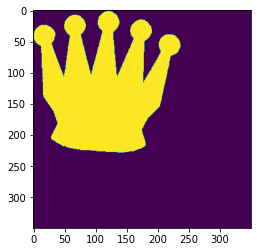

In [114]:
plt.imshow(digits[1])

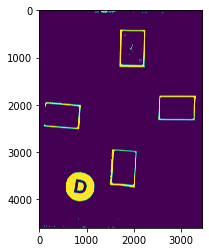

In [57]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(green_contours,kernel,iterations = 2)
plt.imshow(dilation)

In [59]:
hull = []

for i in range(len(contours)):
    
    # creating convex hull object for each contour

    hull.append(cv2.convexHull(contours[i], False))


cntsSorted = sorted(hull, key=lambda x: cv2.contourArea(x))[::-1]

In [90]:
contours_card

[]

In [61]:

ordered_contours_cards = [cntsSorted[i] for i in players_args]

cards_only = cv2.drawContours(cimg.copy(), cntsSorted.copy(), -1, color=255, thickness=-1)

IndexError: ignored

TypeError: ignored

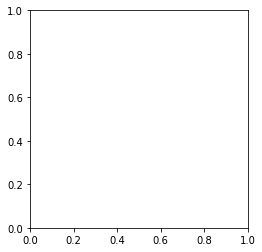

In [79]:
plt.imshow(ordered_contours_cards[0])

In [ ]:
#iterate a l'ordre
#check the problems in exceptions 